In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show

from model import Model

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
gain = 1
P = 50
L = 10
dy2_max = 1

In [3]:
def compute_dy_red(non_linearity, lr, N):
    reductions = []
    D0s = []
    dys = []

    for dy2 in tqdm(np.linspace(0, dy2_max, N)):
        ## Generate data
        inputs = np.array([[-1], [1]])
        outputs = np.array([[1], [1] + (np.sqrt(dy2 / 2)) * np.array([1])])
        names = ["A", "B"]
        data = TensorDataset(
            torch.from_numpy(inputs.astype(np.float32)).to(device),
            torch.from_numpy(outputs.astype(np.float32)).to(device),
        )

        encoding = Encoding(dict(zip(names, inputs)))

        train_datasets = [data]
        val_dataset = [data]

        tracked_datasets = val_dataset + train_datasets

        ## Instantiate model
        model = Model(
            encoding=encoding,
            input_size=inputs.shape[1],
            output_size=outputs.shape[1],
            hidden_dim=P,
            n_hid_layers=L,
            device=device,
            init_std=gain,
            non_linearity=non_linearity,
        )
        # Define Loss, Optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        compiler = Compiler(model, criterion, optimizer)

        # Compute initial difference
        h = get_activations(
            val_dataset, lambda inputs: model(inputs)[1][int(len(model) / 2)], encoding
        )
        h_A, h_B = h.loc[0, "A"].to_numpy(), h.loc[0, "B"].to_numpy()
        h_initial = np.sum((h_B - h_A) ** 2)
        y = get_activations(val_dataset, lambda inputs: model(inputs)[0], encoding)
        y_A, y_B = y.loc[0, "A"].to_numpy(), y.loc[0, "B"].to_numpy()
        y_initial = np.sum((y_B - y_A) ** 2)

        ## Training run
        with io.capture_output() as captured:
            compiler.training_run(
                train_datasets, tracked_datasets, n_epochs=400, batch_size=100
            )

        # Compute final difference
        h = get_activations(
            val_dataset, lambda inputs: model(inputs)[1][int(len(model) / 2)], encoding
        )
        h_A, h_B = h.loc[0, "A"].to_numpy(), h.loc[0, "B"].to_numpy()
        h_final = np.sum((h_B - h_A) ** 2)

        train_loss = compiler.validation(train_datasets)[0][0]
        if train_loss < 0.001:
            reduction = h_final / h_initial
            reductions.append(reduction)
            D0 = y_initial / h_initial
            D0s.append(D0)
            dys.append(dy2)

    return dys, D0s, reductions

In [4]:
N = 5000
dys, D0s, reductions = compute_dy_red(torch.nn.functional.leaky_relu, 0.6 / P, N=N)
# dys, D0s, reductions = compute_dy_red(torch.nn.functional.sigmoid, 200 / P, N=N)
# dys, D0s, reductions = compute_dy_red(torch.nn.functional.elu, 0.06 / P, N=N)

100%|██████████| 5000/5000 [35:53<00:00,  2.32it/s]


In [5]:
print(f"{len(D0s)} out of {N} converged")

4067 out of 5000 converged


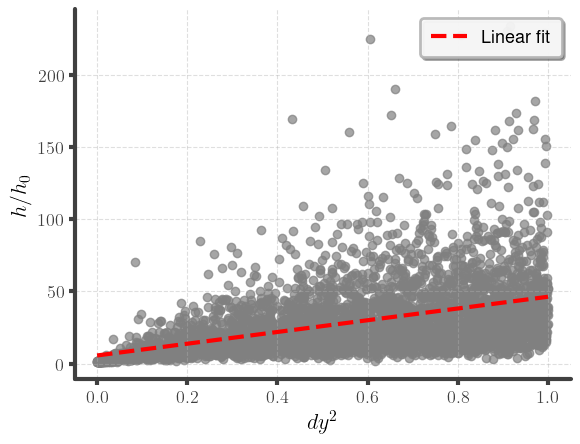

In [30]:
x = np.array(dys)
y = reductions

regr = scipy.stats.linregress(x, y)
a, b = regr.slope, regr.intercept
X = np.linspace(np.min(x), np.max(x), 300)

plt.scatter(x, y)
plt.xlabel("$dy^2$")
plt.ylabel("$h / h_0$")
plt.plot(X, a * X + b, linestyle="--", label="Linear fit", color="red")
plt.legend()
# plt.show()
pub_show()